# 51 序列模型

### 时序模型中，当前数据跟之前观察到的数据相关
### 自回归模型使用自身过去数据来预测未来
#### 马尔科夫模型假设当前只跟最近少数数据相关，从而简化模型
#### 潜变量模型使用潜变量来概括历史信息


# 训练
## 序列模型
生成一些数据：使用正弦函数和一些可加性噪声来生成序列数据， 时间步为1,2,....1000

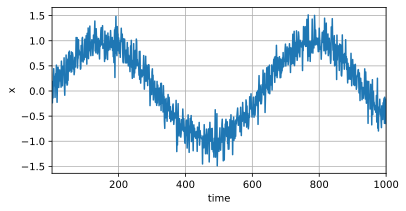

In [1]:
from d2l import torch as d2l
from torch import nn
import torch
%matplotlib inline

T = 1000  # 总共产生1000个点
# [1,....1000]
time = torch.arange(1, T + 1, dtype=torch.float32)
# 正弦函数 + 噪音
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
# x轴时间 y轴[x]
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

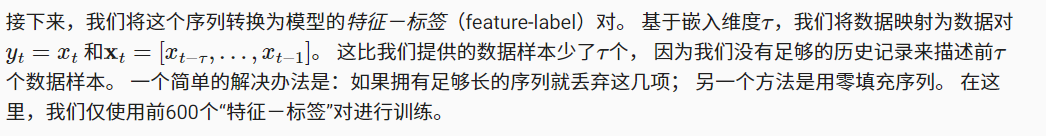

In [18]:
tau = 4
# tau列 T - tau行 
features = torch.zeros((T - tau, tau))
for i in range(tau):
    # 相当于对于feature每行生成xt=[x(t-tau),....,x(t-1)] ，下面是按列生成 先生成每个x的x(t-tau)，最后生成每个x的x(t-1)
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

在这里，我们使用一个相当简单的架构训练模型： 一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失。

In [19]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

## 准备训练模型

In [20]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.088565
epoch 2, loss: 0.059257
epoch 3, loss: 0.055344
epoch 4, loss: 0.053566
epoch 5, loss: 0.053110


## 预测
首先是检查模型预测下一个时间步的能力， 也就是单步预测（one-step-ahead prediction）

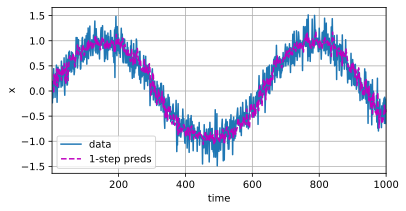

In [21]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

通常，对于直到$x_t$的观测序列，其在时间步t＋k处的预测输出$x_{t+k}$称为k步预测(k-step-ahead-prediction)。</br>
我们必须使用我们自己的预测（而不是原始数据)来进行多步预测。

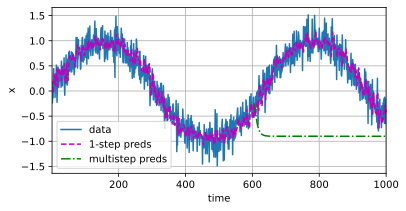

In [26]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

绿线的预测显然并不理想。 经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。 为什么这个算法效果这么差呢？事实是由于错误的累积

基于k =1,4,16,64，通过对整个序列预测的计算，让我们更仔细地看一下k步预测的困难。

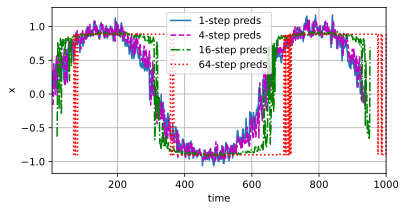

In [23]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
# 最后feature矩阵有64列 前4列是观测值 后面都是预测的值
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

内插法（在现有观测值之间进行估计）和外推法(对超出已知观测范围进行预测）在实践的难度上差别很大。因此，对于所拥有的序列数据，在训练时始终要尊重其时间顺序，即最好不要基于未来的数据进行训练。</br>
序列模型的估计需要专门的统计工具，两种较流行的选择是自回归模型和隐变量自回归模型。</br>
对于时间是向前推进的因果模型，正向估计通常比反向估计更容易。</br>
对于直到时间步t的观测序列，其在时间步t＋k的预测输出是"k步预测'。随着我们对预测时间k值的增加，会造成误差的快速累积和预测质量的极速下降。
